In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [13]:
train_dir = './fer2013/train'
test_dir = './fer2013/test'

In [14]:
import os
for dirpath,dirname,filenames in os.walk('/kaggle/input/fer2013'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

(-0.5, 47.5, 47.5, -0.5)

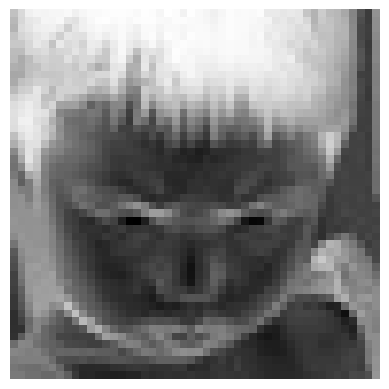

In [15]:
# Let's look at some images
from matplotlib.pyplot import imread
img = imread('./fer2013/train/angry/Training_10118481.jpg')
plt.imshow(img,'binary')
plt.axis(False)

In [64]:
# Load the data and scale it
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory='./fer2013/train',class_mode='binary')
test_data = test_datagen.flow_from_directory(directory='./fer2013/test',class_mode='binary')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
X,y=train_data.next()

In [19]:
(X>1).sum()

0

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
#con 0.003 de Lr , 10 epochs un 45% de aceirto

In [75]:
model_3 = Sequential([
    Conv2D(15,3,activation='relu',padding='same'),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(15,3,activation='relu',padding='same'),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(15,3,activation='relu',padding='same'),
    MaxPool2D(pool_size=(3,3)),
    Flatten(),
    Dense(7,activation='softmax')
])
model_3.compile(optimizer=Adam(0.003), # increasing learning rate as we are going for 5 epochs only(computational power constraint)
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [77]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_3=model_3.fit(train_data,epochs=2,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[reduce_lr, checkpoint])

Epoch 1/2
898/898 [==============================] - ETA: 0s - loss: 1.6418 - accuracy: 0.3571
Epoch 1: val_accuracy improved from -inf to 0.41321, saving model to best_model.h5
898/898 [==============================] - 418s 465ms/step - loss: 1.6418 - accuracy: 0.3571 - val_loss: 1.5227 - val_accuracy: 0.4132 - lr: 0.0010
Epoch 2/2


/home/carlos/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - ETA: 0s - loss: 1.4825 - accuracy: 0.4328
Epoch 2: val_accuracy improved from 0.41321 to 0.44121, saving model to best_model.h5
898/898 [==============================] - 427s 476ms/step - loss: 1.4825 - accuracy: 0.4328 - val_loss: 1.4641 - val_accuracy: 0.4412 - lr: 0.0010


In [78]:
def interpret_prediction(prediction):
    # Asumiendo que 'prediction' es una matriz de probabilidades para cada clase
    class_indices = ['Feliz', 'Triste', 'Enojado', 'Sorprendido', 'Neutral', 'Miedo', 'Disgustado']  # Actualiza según tus clases

    # Obtener el índice de la clase con la mayor probabilidad
    class_index = np.argmax(prediction)

    # Devolver la etiqueta correspondiente
    return class_indices[class_index]


In [59]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Lambda, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Asumiendo img_size = (altura, anchura) y num_classes = 7
input_shape = img_size + (1,)
num_classes = 7  # Actualizar con el número de clases real

input_layer = Input(shape=input_shape)

# Escalar los valores de píxeles al rango que EfficientNet espera
x = Rescaling(scale=1./255)(input_layer)

# Expandir la imagen a 3 canales utilizando tf.cond
def expand_channels(image):
    return tf.cond(tf.shape(image)[-1] == 3, lambda: image, lambda: tf.repeat(image, 3, axis=-1))

x = Lambda(expand_channels)(x)

# Cargar EfficientNetB0 sin los pesos preentrenados y sin la parte superior
efficientnet = EfficientNetB0(include_top=False, input_shape=(None, None, 3), weights=None)

# Pasar la entrada a través de EfficientNet
x = efficientnet(x)

# Agregar capas de clasificación personalizadas
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Finalizar el modelo
final_model = Model(inputs=input_layer, outputs=output)

# Compilar el modelo
final_model.compile(optimizer=Adam(0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo
final_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 299, 299, 1)]     0         
                                                                 
 rescaling_12 (Rescaling)    (None, 299, 299, 1)       0         
                                                                 
 lambda_4 (Lambda)           (None, 299, 299, None)    0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 1024)              1311

In [60]:
from keras.optimizers import Adam

opt=Adam(learning_rate=0.001)
final_model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

In [61]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

epochs=20
batch_size=32

history = final_model.fit(train_data,
                          epochs=20,
                          verbose=1,
                          validation_data=test_data,
                          callbacks=[reduce_lr, checkpoint])

Epoch 1/20
  7/898 [..............................] - ETA: 1:40:39 - loss: 2.1824 - accuracy: 0.2723

KeyboardInterrupt: 